In [1]:
from imblearn.over_sampling import RandomOverSampler

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/drug review SA'

In [ ]:
df = pd.read_csv(PATH + '/data/results/clean_df.csv')

In [ ]:
df.head()

,review,rating,Review_Sentiment,cleaned_reviews,vader_polarity,class,blob_polarity,class_2
0,"""It has no side effect, I take it in combinati...",9,positive,side effect take combination bystolic mg fish oil,0.0000,neutral,0.000000,neutral
1,"""My son is halfway through his fourth week of ...",8,positive,son halfway fourth week intuniv become concern...,0.8892,positve,0.129722,positve
2,"""I used to take another oral contraceptive, wh...",5,neutral,use take another oral contraceptive pill cycle...,0.7964,positve,0.118485,positve
3,"""This is my first time using any form of birth...",8,positive,first time use form birth control glad go patc...,0.5267,positve,0.357143,positve
4,"""Suboxone has completely turned my life around...",9,positive,suboxone completely turn life around feel heal...,0.9260,positve,0.201944,positve


In [ ]:
df = df.drop(['review','rating','vader_polarity', 'Review_Sentiment','blob_polarity', 'class_2' ], axis = 1)

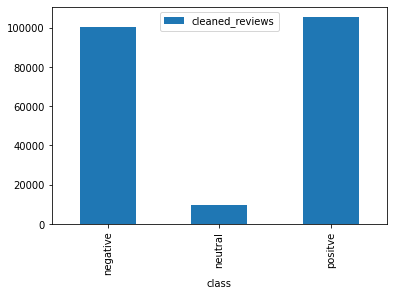

In [ ]:
df.groupby('class').count().plot.bar(ylim=0)
plt.show()

Random over-sampling:
positve     105433
neutral     105433
negative    100071
Name: class, dtype: int64


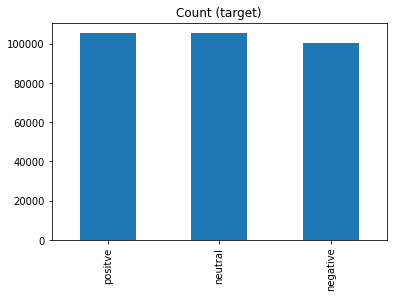

In [ ]:
count_pos, count_neg, count_neu = df['class'].value_counts() 
# Divide by class
df_class_pos = df[df['class'] == 'positve']
df_class_neg = df[df['class'] == 'negative']
df_class_neu = df[df['class'] == 'neutral']

df_class_neu_over = df_class_neu.sample(count_pos, replace=True)
df_test_over = pd.concat([df_class_pos, df_class_neu_over, df_class_neg], axis=0)
 
print('Random over-sampling:')
print(df_test_over['class'].value_counts())

df_test_over['class'].value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
df = df_test_over

In [ ]:
''''

**Label encoder**

In [ ]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder ()
df['class'] = label_encoder.fit_transform(df['class'].values)
df.head()


,cleaned_reviews,class
1,son halfway fourth week intuniv become concern...,2
2,use take another oral contraceptive pill cycle...,2
3,first time use form birth control glad go patc...,2
4,suboxone completely turn life around feel heal...,2
9,pill many year doctor change rx chateal effect...,2


**Train Test Split**

In [ ]:
df.cleaned_reviews =  df.cleaned_reviews.apply(str)

X = df['cleaned_reviews']
Y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

#checking...
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print('number of training data {}' .format(X_train.shape[0]))
print('number of training data {}' .format(X_test.shape[0]))


(248749,)
(62188,)
(248749,)
(62188,)
number of training data 248749
number of training data 62188


In [ ]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = y_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = y_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

**Model Development**

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import *

def model(classifier):
  model_pipeline = Pipeline([

                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=12000, min_df=1,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(classifier)),
            ])
  model_pipeline.fit(X_train, y_train)
  pipeline_prediction = model_pipeline.predict(X_test)
  print('accuracy %s' % accuracy_score(pipeline_prediction, y_test))
  print('recall %s' % recall_score(pipeline_prediction, y_test, average = 'micro'))
  print('precision %s' % precision_score(pipeline_prediction, y_test, average = 'micro'))
  print('f1 score %s' % f1_score(pipeline_prediction, y_test, average = 'micro'))
  return model_pipeline

**SGD classifier**

In [ ]:
from sklearn.linear_model import SGDClassifier
SGD_model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=200, tol=None)
SGD = model(SGD_model)

accuracy 0.7939473853476555
recall 0.7939473853476555
precision 0.7939473853476555
f1 score 0.7939473853476555


**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(multi_class='ovr',solver='liblinear',C=1,random_state=42,tol=0.0001,max_iter=300)
LR = model(LR_model)

accuracy 0.8804110117707596
recall 0.8804110117707596
precision 0.8804110117707596
f1 score 0.8804110117707596


**RandomForest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=100,criterion ='entropy')
RF = model(RF_model)

In [ ]:
import xgboost as xgb
XGB_model = xgb.XGBClassifier(n_jobs=1)
XGB = model(XGB_model)

In [ ]:
from sklearn.svm import SVC
SVC_model = SVC(random_state=42,kernel='linear')
SVC = model(SVC_model)

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
PAG_model = PassiveAggressiveClassifier(random_state=42,max_iter=500,tol=None)
PAG = model(PAG_model)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ADA_model = AdaBoostClassifier(n_estimators=100, random_state=0)
ADA = model(ADA_model)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
EXT_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
EXT = model(EXT_model)